In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from matplotlib.pyplot import imshow
from pathlib import Path
from itertools import combinations
#from src.data.process_dataset import DataGeneratorFromEmbeddings
from src.src_data_process_dataset import DataGeneratorFromEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img

# Recompute edge line assessment for exp 17.1

## Recompute & store assessment scores

Anchor edge line: ../experiments/17.1.remove_minor_segments_thres_0.3/test-val/PM-WWA-20170818-292.jpg
Embedding test_val images
Embedding train images


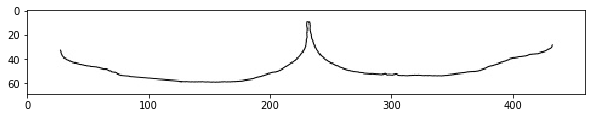

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

TRAIN_PATH = '../experiments/17.1.remove_minor_segments_thres_0.3/train/'
TEST_PATH = '../experiments/17.1.remove_minor_segments_thres_0.3/test-val/'
COMPARE_IMG_PATH = '../experiments/17.1.remove_minor_segments_thres_0.3/test-val/PM-WWA-20170818-292.jpg'
#OUT_FILE = '../experiments/13.3.tuning_edges_new_train_data/' + '39.csv'

# DEFAULT TUTORIAL 2
model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) 

train_data_path = Path(TRAIN_PATH)
train_files_paths = list(train_data_path.glob('*/*.jpg'))  # All file paths
train_files_names = [p.name for p in train_files_paths]  # Only the file names without the full path
train_files_classes = [p.parent.name for p in train_files_paths]  # The parent directory, i.e. the whale ID, for each image

test_data_path = Path(TEST_PATH)
test_files_paths = list(test_data_path.glob('*.jpg'))
test_files_names = [p.name for p in test_files_paths]

train_files = tf.data.Dataset.from_tensor_slices(list(map(str, train_files_paths)))  # Convert paths to strings
train_ds = train_files.map(load_image)  # Apply the load_image function to every image
train_ds = train_ds.batch(BATCH_SIZE)  # Set the batch size

test_files = tf.data.Dataset.from_tensor_slices(list(map(str, test_files_paths)))
test_ds = test_files.map(load_image)
test_ds = test_ds.batch(BATCH_SIZE)

# Selected anchor image
print('Anchor edge line: {}'.format(COMPARE_IMG_PATH))
selected_img = load_img(COMPARE_IMG_PATH)
plt.figure(figsize=(10,3))
plt.imshow(selected_img)

# Compute embedding for selected "typical" image
compare_file_path = [Path(COMPARE_IMG_PATH)]
compare_file = tf.data.Dataset.from_tensor_slices(list(map(str, compare_file_path)))
compare_file_ds = compare_file.map(load_image)
compare_file_ds = compare_file_ds.batch(BATCH_SIZE)
embed_compare = model.predict(compare_file_ds)

# Compute embedding for all test_val images
print('Embedding test_val images')
embed_test = model.predict(test_ds)
# Compute cosine similarity of all test images vs compare image
similarity_matrix = cosine_similarity(embed_test, embed_compare)
test_similarity_scores = similarity_matrix[:,0]

# Compute embedding for all test_val images
print('Embedding train images')
embed_train = model.predict(train_ds)
# Compute cosine similarity of all test images vs compare image
similarity_matrix_train = cosine_similarity(embed_train, embed_compare)
train_similarity_scores = similarity_matrix_train[:,0]

In [6]:
print(len(train_similarity_scores),len(train_files_paths),len(test_similarity_scores),len(test_files_paths))

3956 3956 808 808


In [7]:
df_test_score = pd.DataFrame()
df_test_score['filename'] = [i.name for i in test_files_paths]
df_test_score['filepath'] = test_files_paths
df_test_score['score'] = test_similarity_scores 
df_test_score = df_test_score.sort_values(by=['score'], ascending=False)
df_test_score

,filename,filepath,score
313,PM-WWA-20170818-292.jpg,..\experiments\17.1.remove_minor_segments_thre...,1.000000
175,PM-WWA-20170706-637.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.961540
547,PM-WWA-20180710-354.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.958881
798,PM-WWA-20181019-067.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.958138
330,PM-WWA-20170911-026.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.954751
...,...,...,...
388,PM-WWA-20180407-414.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.415434
390,PM-WWA-20180407-427.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.412987
432,PM-WWA-20180522-163.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.399362
58,PM-WWA-20170530-402.jpg,..\experiments\17.1.remove_minor_segments_thre...,0.379362


In [8]:
df_train_score = pd.DataFrame()
df_train_score['filename'] = [i.name for i in train_files_paths]
df_train_score['filepath'] = train_files_paths
df_train_score['whaleid'] = [i.parent.name for i in train_files_paths]
df_train_score['score'] = train_similarity_scores 
df_train_score = df_train_score.sort_values(by=['score'], ascending=False)
df_train_score

,filename,filepath,whaleid,score
3715,PM-WWA-20150817-098.jpg,..\experiments\17.1.remove_minor_segments_thre...,5739,0.970933
3886,PM-WWA-20160724-108.jpg,..\experiments\17.1.remove_minor_segments_thre...,5893,0.967997
2868,PM-WWA-20110411-139.jpg,..\experiments\17.1.remove_minor_segments_thre...,5019,0.966517
2312,PM-WWA-20080721-010.jpg,..\experiments\17.1.remove_minor_segments_thre...,3650,0.966469
2617,PM-WWA-20090813-156.jpg,..\experiments\17.1.remove_minor_segments_thre...,3850,0.965340
...,...,...,...,...
968,PM-WWA-20050609-014.jpg,..\experiments\17.1.remove_minor_segments_thre...,2889,0.352653
1304,PM-WWA-20050823-130.jpg,..\experiments\17.1.remove_minor_segments_thre...,3027,0.350414
1470,PM-WWA-20060615-A119.jpg,..\experiments\17.1.remove_minor_segments_thre...,3113,0.337560
3648,PM-WWA-20150616-013.jpg,..\experiments\17.1.remove_minor_segments_thre...,5683,0.335715


## Distribution of assessement scores in train images

{'whiskers': [<matplotlib.lines.Line2D at 0x26f967371c8>,
 'caps': [<matplotlib.lines.Line2D at 0x26f96749f48>,
 'boxes': [<matplotlib.lines.Line2D at 0x26f96745c48>],
 'medians': [<matplotlib.lines.Line2D at 0x26f9674ff88>],
 'fliers': [<matplotlib.lines.Line2D at 0x26f96756f88>],
 'means': []}

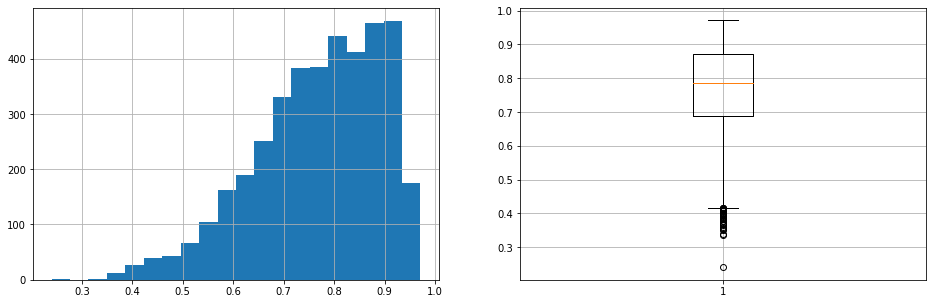

In [10]:
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
plt.grid(axis='both')
plt.hist(train_similarity_scores,bins=20)
ax = plt.subplot(1, 2, 2)
plt.grid(axis='both')
plt.boxplot(train_similarity_scores)

From here we'll decide a threshold from the lower whisker (0.4) to 25% percentile (0.7). Let's see how many train pairs are available with different thresholds.

## Image statistics after removing outliers with different thresholds

In [69]:
def is_similar(pair):
    image_one_class = pair[0][1]
    image_two_class = pair[1][1]
    if image_one_class == image_two_class:
        return 1
    else:
        return 0

In [78]:
for threshold in [0,0.4,0.45,0.5,0.55,0.6,0.65,0.7]:
    # Remove images with similarity score < threshold
    df_train_score_filtered = df_train_score[df_train_score['score'] > threshold]
    # Remove classes having only 1 image
    df_train_2_imgs=df_train_score_filtered[df_train_score_filtered.whaleid.duplicated(keep=False)]

    train_files_names_sorted = df_train_2_imgs['filename'].to_list()
    train_files_clasess_sorted = df_train_2_imgs['whaleid'].to_list()

    train_pairs = list(combinations(zip(train_files_names_sorted, train_files_clasess_sorted), 2))

    train_labels = {pair: is_similar(pair) for pair in train_pairs}
    total = len(train_labels)
    neg_count = sum(value == 0 for value in train_labels.values())
    pos_count = sum(value == 1 for value in train_labels.values())
    print(f"***** THRESHOLD = {threshold} *****")
    print(f"Total whales = {len(set(train_files_clasess_sorted))}")
    print(f"Total images = {len(train_files_names_sorted)}")
    print(f"Images removed = {len(df_train_score['filename'].to_list()) - len(train_files_names_sorted)}")
    print(f"Total pairs = {total}")
    print(f"Different pairs = {neg_count}")
    print(f"Same pairs = {pos_count}")
    print(f"***********************************")

***** THRESHOLD = 0 *****
Total whales = 565
Total images = 2288
Images removed = 1668
Total pairs = 2616328
Different pairs = 2609067
Same pairs = 7261
***********************************
***** THRESHOLD = 0.4 *****
Total whales = 559
Total images = 2269
Images removed = 1687
Total pairs = 2573046
Different pairs = 2565832
Same pairs = 7214
***********************************
***** THRESHOLD = 0.45 *****
Total whales = 550
Total images = 2239
Images removed = 1717
Total pairs = 2505441
Different pairs = 2498327
Same pairs = 7114
***********************************
***** THRESHOLD = 0.5 *****
Total whales = 541
Total images = 2206
Images removed = 1750
Total pairs = 2432115
Different pairs = 2425120
Same pairs = 6995
***********************************
***** THRESHOLD = 0.55 *****
Total whales = 519
Total images = 2117
Images removed = 1839
Total pairs = 2239786
Different pairs = 2233119
Same pairs = 6667
***********************************
***** THRESHOLD = 0.6 *****
Total whales = 48

0.65 looks good (also visually verified in "edge assessment browse.qvw")

# Copy train images without outliers to new dataset

In [87]:
import errno
import os
import shutil

In [98]:
# Function to copy file from source to dest, create folder if doesn't exist
# https://stackoverflow.com/questions/2793789/create-destination-path-for-shutil-copy-files/3284204
def copy_create_path(src, dest):
    try:
        shutil.copy(src, dest)
    except IOError as e:
        # ENOENT(2): file does not exist, raised also on missing dest parent dir
        if e.errno != errno.ENOENT:
            raise
        # try creating parent directories
        os.makedirs(os.path.dirname(dest))
        shutil.copy(src, dest)

In [104]:
SCORE_THRESHOLD = 0.65
NEW_PATH = '../experiments/18.1.remove_outliers_sim_score_threshold_0.65/train/'

#remove images with similarity score < SCORE_THRESHOLD
df_train_score_filtered = df_train_score[df_train_score['score'] > SCORE_THRESHOLD]
# Remove classes having only 1 image
df_train_2_imgs=df_train_score_filtered[df_train_score_filtered.whaleid.duplicated(keep=False)]
filtered_train_image_paths = df_train_2_imgs['filepath']
for p in filtered_train_image_paths:
    old_path = Path(p)
    new_path = Path(os.path.join(NEW_PATH, old_path.parent.name, old_path.name))
    copy_create_path(old_path, new_path)

In [100]:
new_path

WindowsPath('../experiment/18.1.remove_outliers_sim_score_threshold_0.65/3186/PM-WWA-20110914-005.jpg')